# AMR-Wind simulation post-processing & analysis

## Import necessary functions & set case folder

In [35]:
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import netCDF4 as ncdf
import pandas as pd
import os
import post_processing as pp
from IPython.display import display, clear_output
%matplotlib notebook

# Set folder where data is found here:
base_folder = '/scratch/jfrederi/moa_python/initial_case_studies'
case_folder = '060_neutral_lowti/turbineSim/post_processing'

## Analyze statistics data

This part of the code loads and plots data from the abl_statistics file containing the mean profiles

### Load statistics data

In [27]:
# Set specific abl statistics case file here:
stats_file = 'abl_statistics00000.nc'

# Load statistics data
stats_folder = os.path.join(base_folder, case_folder)
dstat = ncdf.Dataset(os.path.join(stats_folder, stats_file))

## "dstat" usually contains the following:
#  variables: time, Q, Tsurf, ustar, wstar, L, zi, abl_forcing_x, abl_forcing_y
#  groups: mean_profiles

mean_profiles = pp.get_group_from_abl_stats(stats_folder, stats_file, "mean_profiles")

## "mean_profiles" usually contains the following:
#  variables: h(nlevels), u(num_time_steps, nlevels), v(num_time_steps, nlevels), w(num_time_steps, nlevels)
#       hvelmag(num_time_steps, nlevels), theta(num_time_steps, nlevels), mueff(num_time_steps, nlevels)
#       theta'theta'_r(num_time_steps, nlevels), u'theta'_r(num_time_steps, nlevels), v'theta'_r(num_time_steps, nlevels)
#       w'theta'_r(num_time_steps, nlevels), u'u'_r(num_time_steps, nlevels), u'v'_r(num_time_steps, nlevels)
#       u'w'_r(num_time_steps, nlevels), v'v'_r(num_time_steps, nlevels), v'w'_r(num_time_steps, nlevels)
#       w'w'_r(num_time_steps, nlevels), u'u'u'_r(num_time_steps, nlevels), v'v'v'_r(num_time_steps, nlevels)
#       w'w'w'_r(num_time_steps, nlevels), u'theta'_sfs(num_time_steps, nlevels), v'theta'_sfs(num_time_steps, nlevels)
#       w'theta'_sfs(num_time_steps, nlevels), u'v'_sfs(num_time_steps, nlevels), u'w'_sfs(num_time_steps, nlevels)
#       v'w'_sfs(num_time_steps, nlevels)

u_stats = pp.get_data_from_group(mean_profiles,"u")
v_stats = pp.get_data_from_group(mean_profiles,"v")
h_stats = pp.get_data_from_group(mean_profiles,"h")
time_stats = pp.get_data_from_abl_stats(stats_folder,stats_file,"time")

### Process & plot statistics data

<IPython.core.display.Javascript object>


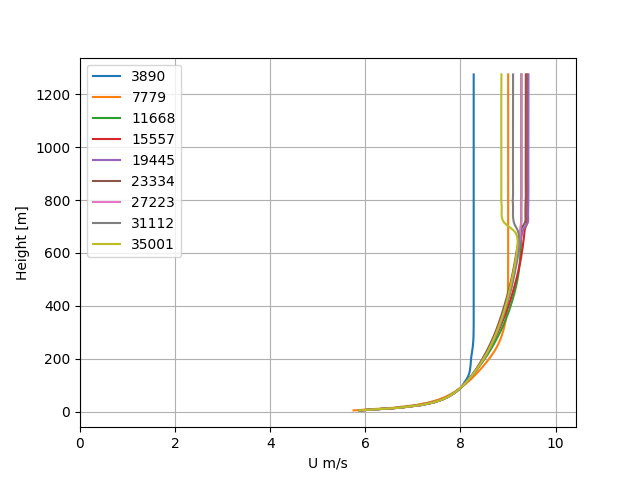

In [52]:
# Set time span you are interested in
t0_stats = 1
tend_stats = 35001
N_stats = 10

# Define variables
timespan_stats = np.around(np.linspace(t0_stats,tend_stats,N_stats))
umag_stats = pp.get_ws_magnitude(u_stats,v_stats)
uavg_stats = pp.average_vel_data(umag_stats,time_stats,timespan_stats)

pp.plot_vert_vel_profiles(uavg_stats,h_stats)
ax = plt.gca()
legendindex = np.append(timespan_stats[1:-1],tend_stats)
ax.legend(legendindex.astype(int))

## Analyze plane data

This part of the code plots and analyzes data from plane sampling data out of AMR-Wind

### Load plane data

In [36]:
# Set specific case folder and file here:
plane_file = 'samplingPlane18000.nc'

# Load statistics data
plane_folder = os.path.join(base_folder, case_folder)
plane_data = pp.get_group_from_abl_stats(plane_folder,plane_file,"z_plane")
plane_time = list(pp.get_data_from_abl_stats(plane_folder,plane_file,"time")[:])

## "plane_data" usually contains
#  variables: coordinates(num_points, ndim), velocityx(num_time_steps, num_points)
#       velocityy(num_time_steps, num_points), velocityz(num_time_steps, num_points)
#       temperature(num_time_steps, num_points)

### Process & plot z-plane data

<IPython.core.display.Javascript object>


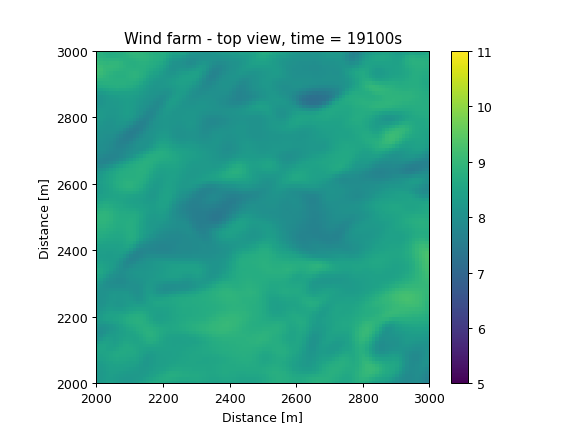

[8.03219047 8.02456518 7.96821765 ... 7.98249797 7.95423085 7.96394954]


(2000.0, 3000.0)

In [37]:
# Select data that you are interested in
h_des = 155        # height of velocity plot
vmin = 5           # colormap minimum
vmax = 11          # colormap maximum
t0_plane = 19100   # begin time of plot
tend_plane = 19100 # end time plot

# Extract data from plane
u_plane = pp.get_data_from_group(plane_data,'velocityx')
v_plane = pp.get_data_from_group(plane_data,'velocityy')
w_plane = pp.get_data_from_group(plane_data,'velocityz')
plane_coor = pp.get_data_from_group(plane_data,'coordinates')
T_plane = pp.get_data_from_group(plane_data,'temperature')
umag_plane = pp.get_ws_magnitude(u_plane,v_plane)

# Process data
tvec = np.array(plane_time)
ind = np.where(plane_coor[:,2] == h_des)[0]
Nt = len(tvec)
xgrid = np.unique(plane_coor[ind,0])
ygrid = np.unique(plane_coor[ind,1])
Nx = np.size(xgrid)
Ny = np.size(ygrid)
tind = np.where((tvec >= t0_plane) & (tvec <= tend_plane))[0]

figplane, axplane = plt.subplots()
n = 0
#for t in tvec[tind]:
axplane.cla()
print(umag_plane[0,ind])
ugrid = np.reshape(umag_plane[1,ind], (Nx,Ny))

# Plot figure
im = axplane.pcolor(xgrid,ygrid, ugrid,vmin=5,vmax=11)
axplane.set_aspect('equal')
figplane.colorbar(im, ax=axplane)
plt.xlabel('Distance [m]')
plt.ylabel('Distance [m]')
plt.title(f'Wind farm - top view, time = {tend_plane}s')
plt.xlim(2000,3000)
plt.ylim(2000,3000)

    #display(figplane)
    #clear_output(wait = True)
    #plt.pause(0.2)
    #n += 1

## Analyze turbine output
This code analyzes the outputs from actuators like an OpenFAST turbine.

### Import actuator data

In [34]:
# Set specific file here:
base_folder = '\\wsl.localhost\Debian\home\jfrederi\ROSCO\Simulations' #temporarily
case_folder ='Baseline' #temporarily
act_file = 'actuator18000/WTG01.nc'
act_type = 'openfast'

match act_type:
    case 'adm':
        # Load statistics data
        act_folder = os.path.join(base_folder, case_folder)
        act_data = pp.get_group_from_abl_stats(act_folder,act_file,"WTG01")
        print(act_data)

        ct = pp.get_data_from_group(act_data,'ct')
        vdisk = pp.get_data_from_group(act_data,'vdisk')
        vref = pp.get_data_from_group(act_data,'vref')
        print(vref-vdisk)
    case 'openfast':
        # Load OpenFAST data
        act_folder = os.path.join(base_folder, case_folder)
        act_data = 

<class 'netCDF4._netCDF4.Group'>
group /WTG01:
    normal: [-0.8660254 -0.5        0.       ]
    sample_normal: [-1.0000000e+00 -1.8369702e-16  0.0000000e+00]
    diameter: 126.0
    epsilon: 10.0
    sample_diameters: 1.0
    dimensions(sizes): num_actuator_points(5), num_velocity_points(30)
    variables(dimensions): float64 time(num_time_steps), float64 xyz(num_actuator_points, ndim), float64 xyz_v(num_velocity_points, ndim), float64 vref(num_time_steps, ndim), float64 vdisk(num_time_steps, ndim), float64 ct(num_time_steps), float64 density(num_time_steps)
    groups: 
[[ 9.83670010e-02  9.65714653e-02  1.23889517e-03]
 [ 2.20306830e-01  1.75423305e-01  9.00408853e-04]
 [ 3.32298596e-01  2.38828124e-01  4.39425395e-04]
 [ 4.31288207e-01  2.89751894e-01 -1.79892623e-04]
 [ 5.16411923e-01  3.31215412e-01 -9.64524081e-04]
 [ 5.88951259e-01  3.65671188e-01 -1.91804779e-03]
 [ 6.50960707e-01  3.95222705e-01 -2.96795360e-03]
 [ 7.04491398e-01  4.21304390e-01 -3.94238942e-03]
 [ 7.5126480